# Data Cleansing
<a id="0"></a> <br>
In this notebook, the Data Cleansing for the project "Mietpreisprognose im Schweizer Wohnungsmarkt" is presented.

1. [Setup](#1)
    - [DB Connection SQL Server](#2)
    - [DB Connection MySQL](#3)
2. [Data Cleansing for Location and Property](#4)
    - [Check for Empty Entries and Filter Records](#5)
    - [Cleansing Outliers](#6)
    - [Cleansing Longitude and Latitude](#7)
    - [Cleansing Population Density](#8)
3. [Data Cleansing for Property Additional Feature](#9)
4. [Enrich Data](#10)
    - [One-Hot-Encoding](#11)
    - [Add Price per m2](#12)
5. [Export Clean Dataframe](#13)

<a id="1"></a> 
## Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import os
import seaborn as sns
import statsmodels.api as sm
import pylab as py

# seaborn graphics settings
sns.set(color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

C:\Users\AnninaBerweger\datascience-immo\Immo-Projekt-DataScience


<a id="2"></a> 
### DB Connection SQL Server

In [5]:
#DB-Connection 
driver = '{ODBC Driver 17 for SQL Server}' # This might be a different version on your system
server = 'ANNINAYOGA\SQLEXPRESS'
database = 'Immo'
username = 'immoadmin'
password = 'zhaw$1234'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;"

In [6]:
#Connection and SQL-Query for table property
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM property"
df_property = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

#Connection and SQL-Query for table location
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM location"
df_location = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

# Performing a inner join on the two DataFrames to filter data which do not exist on location due to connection issues
df_filtered_property_location = pd.merge(df_property, df_location,on='LocationId', how='inner')

#Connection and SQL-Query for table PropertyAdditionalFeatures
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM PropertyAdditionalFeatures"
df_data_PropertyAdditionalFeatures = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]

cnxn.close()

<a id="3"></a> 
### DB Connection MySQL

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# Database connection details
db_config = {
    'host': '127.0.0.1',
    'port': '13306',
    'user': 'admin',
    'password': 'admin123',
    'database': 'immo'
}

# Create the engine
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# Querying the property table
query_property = "SELECT * FROM Property"
df_property = pd.read_sql(query_property, engine)

# Querying the location table
query_location = "SELECT * FROM Location"
df_location = pd.read_sql(query_location, engine)

# Performing an inner join on the two DataFrames
df_filtered_property_location = pd.merge(df_property, df_location, on='LocationId', how='inner')

# Close the connection
engine.dispose()


<a id="4"></a> 
## Data Cleansing for Location and Property

In [20]:
#Show head of df df_filtered_property_location
df_filtered_property_location.head()

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
0,4000339592,2024-03-26 20:51:38,2.5,93.0,1,Sofort,Wohnung,2020-01-01,1920.0,NaN,...,5254,Mendrisio,97,77,97,77,468,1,0,0
1,4000280848,2024-03-26 20:51:50,2.5,62.0,2,Sofort,Wohnung,2017-01-01,1730.0,280.0,...,5263,Riva San Vitale,97,80,97,80,437,5,1,3
2,4000653378,2024-03-26 21:52:37,2.0,58.0,3,Nach Vereinbarung,Wohnung,None,910.0,160.0,...,5257,Morbio Inferiore,97,84,97,84,1'999,6,0,2
3,4000381531,2024-03-26 22:44:33,1.5,40.0,None,Sofort,Wohnung,None,1350.0,100.0,...,5192,Lugano,97,77,97,77,825,4,0,3
4,4000263143,2024-03-26 20:52:41,2.5,50.0,99,Nach Vereinbarung,Wohnung,None,1300.0,NaN,...,5154,Bissone,97,69,97,69,491,1,0,0


In [21]:
#Show info of df df_filtered_property_location. Total of 11289 entries
df_filtered_property_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11289 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     11289 non-null  object        
 1   Timestamp                     11289 non-null  datetime64[ns]
 2   Rooms                         10890 non-null  float64       
 3   SquareMeter                   9291 non-null   float64       
 4   Floor                         9573 non-null   object        
 5   Availability                  11288 non-null  object        
 6   ObjectType                    11288 non-null  object        
 7   YearBuilt                     4966 non-null   object        
 8   Price                         11289 non-null  float64       
 9   AdditionalCost                9265 non-null   float64       
 10  NetPrice                      10050 non-null  float64       
 11  LocationId                  

<a id="5"></a> 
### Check for Empty Entries and Filter Records

In [22]:
#Check for duplicates - no duplicates found
df_filtered_property_location.duplicated().sum()

0

In [73]:
#dataframe df_filtered_property_location_clean  
#ObjectType where Einzelzimmer, Estrichabteil, Hobbyraum, Kellerabteil - filtered
#Rooms where NULL - filtered
#SquareMeter where NULL - filtered
#total: 9024 entries (original: 11298 entries)
#Outliers - check Outliers of Prices, Rooms and SquareMeters. Eliminate manually where not noisy data 
#total after eliminating noisy data: 9000 entries (original 11295 entries)

In [23]:
# filter out records with empty strings in the 'Rooms' column - new dataframe: df_filtered_property_location_clean
df_filtered_property_location_clean = df_filtered_property_location[df_filtered_property_location['Rooms'].notna()]

In [24]:
#Check ObjectTypes
df_filtered_property_location_clean.groupby("ObjectType").size()

ObjectType
Attikawohnung             317
Bauernhaus                  6
Chalet                     35
Dachwohnung               299
Doppeleinfamilienhaus      27
Einfamilienhaus           274
Einliegerwohnung            9
Einzelzimmer               26
Estrichabteil               1
Hobbyraum                  27
Kellerabteil                3
Loft                       55
Maisonette / Duplex       355
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    123
Terrassenhaus               4
Terrassenwohnung           37
Villa                      66
Wohnung                  9164
dtype: int64

In [25]:
#Filter where ObjectType != Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil
df_filtered_property_location_clean = df_filtered_property_location[(df_filtered_property_location['ObjectType'] != 'Einzelzimmer') & (df_filtered_property_location['ObjectType'] != 'Estrichabteil') & (df_filtered_property_location['ObjectType'] != 'Hobbyraum') & (df_filtered_property_location['ObjectType'] != 'Kellerabteil')]

#Check ObjectTypes - Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil are filtered
df_filtered_property_location_clean.groupby("ObjectType").size()

ObjectType
Attikawohnung             318
Bauernhaus                  6
Chalet                     40
Dachwohnung               300
Doppeleinfamilienhaus      28
Einfamilienhaus           281
Einliegerwohnung            9
Loft                       71
Maisonette / Duplex       359
Mansarde                    1
Mehrfamilienhaus            2
Reihenfamilienhaus         58
Studio                    151
Terrassenhaus               4
Terrassenwohnung           38
Villa                      66
Wohnung                  9323
dtype: int64

In [26]:
# filter out records with empty strings in the 'Rooms' and 'SquareMeters' column
df_filtered_property_location_clean = df_filtered_property_location_clean.dropna(subset=['Rooms', 'SquareMeter'])

#Check for empty records
df_filtered_property_location_clean.isnull().sum()

ListingId                          0
Timestamp                          0
Rooms                              0
SquareMeter                        0
Floor                           1075
Availability                       0
ObjectType                         0
YearBuilt                       4403
Price                              0
AdditionalCost                  1460
NetPrice                         899
LocationId                         0
PropertyAdditionalFeaturesId       0
PropertyDescription               36
Vendor                           648
Canton                             0
street                           549
zip                                0
longitude                          0
latitude                           0
bfs_number                         0
municipality                       0
incometax_canton                   0
incometax_municipality             0
wealthtax_canton                   0
wealthtax_municipality             0
population_density                47
p

In [27]:
#9019 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8985 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     8985 non-null   object        
 1   Timestamp                     8985 non-null   datetime64[ns]
 2   Rooms                         8985 non-null   float64       
 3   SquareMeter                   8985 non-null   float64       
 4   Floor                         7910 non-null   object        
 5   Availability                  8985 non-null   object        
 6   ObjectType                    8985 non-null   object        
 7   YearBuilt                     4582 non-null   object        
 8   Price                         8985 non-null   float64       
 9   AdditionalCost                7525 non-null   float64       
 10  NetPrice                      8086 non-null   float64       
 11  LocationId                    8985

<a id="6"></a> 
### Cleansing Outliers

<Axes: xlabel='SquareMeter'>

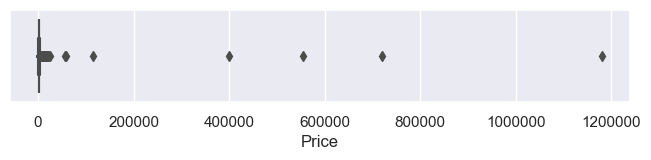

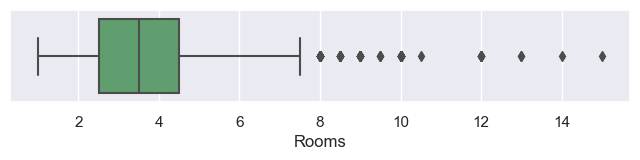

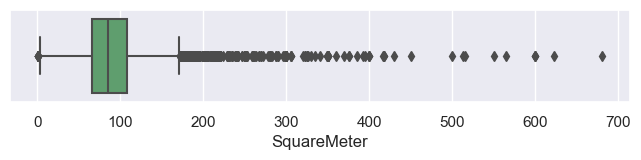

In [28]:
#Boxplots for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="g")

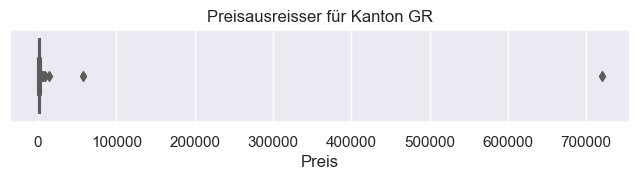

In [29]:
#Show outlier for specific canton
df_gr = df_filtered_property_location_clean[df_filtered_property_location_clean['Canton'] == 'gr']
plt.figure(figsize=(8, 1.2))
plt.ticklabel_format(style='plain')  # Stellt sicher, dass die Preise im normalen Zahlenformat angezeigt werden
sns.boxplot(x=df_gr['Price'], color="greenyellow")  # Erstellen des Boxplots mit der angegebenen Farbe

plt.title('Preisausreisser für Kanton GR')  # Hinzufügen eines Titels zum Plot
plt.xlabel('Preis')  # Beschriftung der X-Achse
plt.show()

In [30]:
#Detect outliers (Price) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Price'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Price'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Price', ascending=False)
    
    # Display sorted outliers
    print("Outliers found, sorted by highest price:")
    display(outliers_sorted)


Outliers found, sorted by highest price:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
9841,4000895043,2024-03-29 14:01:53,4.5,92.0,EG,15.12.2024,Wohnung,None,1180000.0,NaN,...,5422,Aubonne,155,70,155,70,265,3,1,4
7409,4000956535,2024-03-27 14:46:17,3.5,139.0,EG,Nach Vereinbarung,Wohnung,1965-01-01,720000.0,NaN,...,3847,Val Müstair,100,120,100,120,7,2,0,1
8301,4000834270,2024-03-26 05:49:47,2.5,67.0,EG,31.03.2027,Wohnung,2024-01-01,554000.0,NaN,...,5266,Stabio,97,65,97,65,733,5,2,2
7880,4000895759,2024-03-25 21:29:48,2.5,63.0,EG,Sofort,Wohnung,2023-01-01,399000.0,NaN,...,5239,Tresa,97,85,97,85,None,2,0,0
6201,3003516605,2024-03-24 13:08:32,10.0,350.0,None,Sofort,Chalet,1930-01-01,115000.0,NaN,...,843,Saanen,302.5,120,302.5,120,57,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,4000940351,2024-03-29 09:55:30,5.5,142.0,EG,01.06.2024,Wohnung,None,3714.0,440.0,...,2770,Muttenz,100,56,100,56,1'075,6,1,3
5663,4000875126,2024-03-24 03:49:49,2.5,50.0,None,Nach Vereinbarung,Attikawohnung,None,3710.0,230.0,...,261,Zürich,99,119,99,119,4'779,4,2,54
9583,4000775376,2024-03-29 13:02:29,3.5,130.0,7,01.05.2024,Wohnung,2023-01-01,3710.0,NaN,...,5583,Crissier,155,63.5,155,63.5,1'448,4,0,0
4983,4000871472,2024-03-24 01:50:10,2.5,109.0,1,01.07.2024,Wohnung,1961-01-01,3705.0,330.0,...,261,Zürich,99,119,99,119,4'779,6,1,5


In [31]:
#Detect outliers (Rooms) and list them

# Set display options
pd.set_option('display.max_rows', 500)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['Rooms'].quantile(0.25)
Q3 = df_filtered_property_location_clean['Rooms'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['Price'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='Rooms', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest Rooms:")
    display(outliers_sorted)

Outliers found, sorted by highest Rooms:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
8092,4000747603,2024-03-26 23:12:08,15.0,43.0,99,Nach Vereinbarung,Wohnung,None,2900.0,NaN,...,5192,Lugano,97,77,97,77,825,8,2,14
3077,4000360406,2024-03-26 22:45:34,14.0,416.0,None,Nach Vereinbarung,Wohnung,None,6760.0,NaN,...,5257,Morbio Inferiore,97,84,97,84,1'999,4,0,1
11140,4000853321,2024-03-29 22:28:33,13.0,418.0,3,Sofort,Wohnung,None,12700.0,800.0,...,6621,Genève,147.5,45.49,147.5,45.49,12'811,6,3,7
11154,4000976047,2024-03-29 22:33:07,13.0,418.0,None,Nach Vereinbarung,Wohnung,None,12200.0,800.0,...,6621,Genève,147.5,45.49,147.5,45.49,12'811,8,2,12
11062,4000897434,2024-03-29 22:12:36,12.0,513.0,None,Sofort,Einfamilienhaus,None,20000.0,NaN,...,1406,Sachseln,335,470,335,470,96,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4000860087,2024-03-27 21:03:08,1.0,36.0,2,01.06.2024,Wohnung,1980-01-01,1169.0,180.0,...,4038,Obersiggenthal,112,110,112,110,1'032,3,3,5
1682,4000860806,2024-03-27 14:32:25,1.0,36.0,EG,Sofort,Wohnung,1997-01-01,1100.0,NaN,...,3788,S-chanf,100,65,100,65,5,1,0,1
9477,4000892128,2024-03-29 12:36:49,1.0,40.0,5,01.06.2024,Wohnung,None,1375.0,110.0,...,2701,Basel,50,50,50,50,7'263,7,4,8
1011,4000965686,2024-03-27 21:15:43,1.0,32.0,2,01.04.2024,Wohnung,2020-01-01,850.0,100.0,...,4135,Gontenschwil,112,112,112,112,223,2,0,1


In [32]:
#detect outliers (SquareMeter) and list them

# Set display options
pd.set_option('display.max_rows', 50)

# Calculation of the first (Q1) and third quartiles (Q3) for Price across the entire DataFrame
Q1 = df_filtered_property_location_clean['SquareMeter'].quantile(0.25)
Q3 = df_filtered_property_location_clean['SquareMeter'].quantile(0.75)
IQR = Q3 - Q1

# Boundaries for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers
outliers = df_filtered_property_location_clean[(df_filtered_property_location_clean['SquareMeter'] < lower_bound) | (df_filtered_property_location_clean['Price'] > upper_bound)]

# Feedback if there are any outliers
if outliers.empty:
    print("No outliers found.")
else:
    # Sort the outliers by the 'Price' column in descending order
    outliers_sorted = outliers.sort_values(by='SquareMeter', ascending=False)
    
    # Display the sorted outliers
    print("Outliers found, sorted by highest SquareMeter:")
    display(outliers_sorted)

Outliers found, sorted by highest SquareMeter:


,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,bfs_number,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count
88,4000634700,2024-03-26 21:53:23,6.5,680.0,EG,Nach Vereinbarung,Villa,2012-01-01,20000.0,NaN,...,5176,Comano,97,75,97,75,994,0,0,0
2687,4000869508,2024-03-27 08:42:30,10.0,622.0,None,Nach Vereinbarung,Villa,1986-01-01,9900.0,NaN,...,3024,Teufen (AR),330,260,330,260,417,2,0,1
8221,4000611388,2024-03-25 22:19:29,7.5,600.0,None,Nach Vereinbarung,Einfamilienhaus,None,18000.0,NaN,...,5192,Lugano,97,77,97,77,825,19,0,44
9920,3000029481,2024-03-29 14:20:24,8.0,600.0,None,Sofort,Chalet,2008-01-01,10000.0,NaN,...,1406,Sachseln,335,470,335,470,96,0,0,0
10245,4000943404,2024-03-29 18:13:13,12.0,600.0,None,Nach Vereinbarung,Chalet,None,13000.0,NaN,...,6240,Lens,100,105,100,105,302,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377,4000797599,2024-03-27 15:02:52,5.5,1.0,None,Nach Vereinbarung,Einfamilienhaus,None,1000.0,NaN,...,3714,Rheinwald,100,100,100,100,4,3,1,2
5654,4000969516,2024-03-29 00:19:45,3.0,1.0,2,Sofort,Wohnung,None,1370.0,NaN,...,6458,Neuchâtel,125,65,125,65,1'483,18,2,40
3514,4000965774,2024-03-27 22:12:51,2.5,1.0,1,01.06.2024,Wohnung,None,1326.0,160.0,...,4141,Reinach (AG),112,115,112,115,927,4,2,10
1494,4000924121,2024-03-27 15:05:59,3.5,1.0,None,Nach Vereinbarung,Wohnung,None,58000.0,NaN,...,3851,Davos,100,103,100,103,38,0,0,0


In [33]:
#Outliers manually checked if records is valid or not (if not valid (selling house instead of renting), to delete
# List of ListingIds to be removed (selling instead of renting objects, shared apartments,...)
ids_to_remove = ['4000895043','4000834270','4000895759','3003516605','4000910516','4000956535','4000924121','4000975051','4000888412','4000945522','4000869481','4000969667','4000838419','4000870455','4000904681','4000931326','4000969684','4000969684','4000797599','4000897187','4000969553','4000969553','4000965774','4000962388','4000969516','4000906960']  
df_filtered_property_location_clean = df_filtered_property_location_clean[~df_filtered_property_location_clean['ListingId'].isin(ids_to_remove)]


<a id="7"></a> 
### Cleansing Longitude and Latitude

In [34]:
# Gruppieren nach 'longitude' und 'latitude' und Auflisten der 'ListingId' für jede Gruppe
grouped = df_filtered_property_location_clean.groupby(['longitude', 'latitude'])['ListingId'].apply(list)

# Filtern nach Gruppen mit mehr als zwei Einträgen
multiple_entries = grouped[grouped.apply(len) > 3]

# Überprüfen, ob es solche Gruppen gibt und sie als neue CSV speichern
if not multiple_entries.empty:
    print("Es gibt Einträge mit denselben Longitude- und Latitude-Werten, bei denen mehr als drei ListingsIDs vorhanden sind. Speichern der Ergebnisse in einer CSV-Datei.")
    # Umformen der Serie in ein DataFrame für eine klarere Darstellung
    multiple_entries_df = multiple_entries.reset_index()
    multiple_entries_df.columns = ['Longitude', 'Latitude', 'ListingIds']
    # Speichern in einer CSV-Datei
    multiple_entries_df.to_csv('listings_with_more_than_three_same_coordinates.csv', index=False)
else:
    print("Es gibt keine Einträge mit denselben Longitude- und Latitude-Werten, bei denen mehr als drei ListingsIDs vorhanden sind.")


Es gibt Einträge mit denselben Longitude- und Latitude-Werten, bei denen mehr als drei ListingsIDs vorhanden sind. Speichern der Ergebnisse in einer CSV-Datei.


In [35]:
# Anzahl der Einträge im DataFrame ermitteln
num_entries = len(df_filtered_property_location_clean)

# Anzeigen der Anzahl der Einträge
print("Anzahl der Einträge im DataFrame:", num_entries)

Anzahl der Einträge im DataFrame: 8964


In [36]:
# Konvertierung 'latitude' und 'longitude' zu Float
df_filtered_property_location_clean['latitude'] = pd.to_numeric(df_filtered_property_location_clean['latitude'], errors='coerce')
df_filtered_property_location_clean['longitude'] = pd.to_numeric(df_filtered_property_location_clean['longitude'], errors='coerce')

# Koordinaten, die nicht korrekt gesetzt wurden nach manueller Überprüfung
specific_latitude = 46.818188
specific_longitude = 8.227511999999999

# Filtern des DataFrames für die exakte Übereinstimmung der Koordinaten
specific_entries = df_filtered_property_location_clean[
    (df_filtered_property_location_clean['latitude'] == specific_latitude) &
    (df_filtered_property_location_clean['longitude'] == specific_longitude)
]

# Entfernen dieser Einträge aus dem DataFrame
df_filtered_property_location_clean = df_filtered_property_location_clean.drop(specific_entries.index)

# Überprüfen, ob die Einträge erfolgreich entfernt wurden
if specific_entries.index.isin(df_filtered_property_location_clean.index).any():
    print("Einige Einträge wurden nicht erfolgreich entfernt.")
else:
    print("Alle spezifischen Einträge wurden erfolgreich aus dem DataFrame entfernt.")

Alle spezifischen Einträge wurden erfolgreich aus dem DataFrame entfernt.


In [37]:
#8995 entries after filtered
df_filtered_property_location_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8830 entries, 0 to 11288
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     8830 non-null   object        
 1   Timestamp                     8830 non-null   datetime64[ns]
 2   Rooms                         8830 non-null   float64       
 3   SquareMeter                   8830 non-null   float64       
 4   Floor                         7823 non-null   object        
 5   Availability                  8830 non-null   object        
 6   ObjectType                    8830 non-null   object        
 7   YearBuilt                     4523 non-null   object        
 8   Price                         8830 non-null   float64       
 9   AdditionalCost                7456 non-null   float64       
 10  NetPrice                      7986 non-null   float64       
 11  LocationId                    8830

<Axes: xlabel='SquareMeter'>

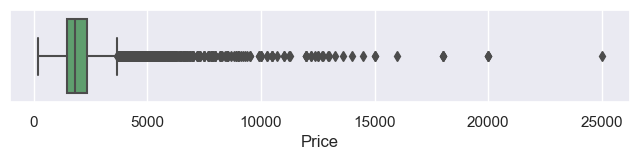

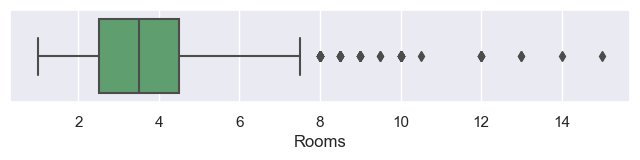

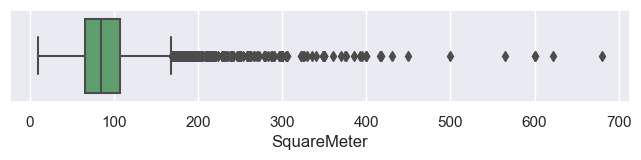

In [38]:
#Boxplots after eliminating noisy data for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="g")

<a id="8"></a> 
### Cleansing Population Density

In [39]:
# Entfernung Apostroph aus der gesamten Spalte und Konvertierung zu Float, dann zu String
df_filtered_property_location_clean['population_density'] = (
    df_filtered_property_location_clean['population_density']
    .str.replace("'", "")  # Entferne das Apostroph aus jedem Eintrag
    .astype(float)         # Konvertiere den bereinigten String zu Float
    .astype(str)           # Konvertiere den Float zurück zu String
)

# Ergebnis check, um sicherzustellen, dass die Änderung korrekt angewandt wurde
print(df_filtered_property_location_clean)

        ListingId           Timestamp  Rooms  SquareMeter Floor  \
0      4000339592 2024-03-26 20:51:38    2.5         93.0     1   
1      4000280848 2024-03-26 20:51:50    2.5         62.0     2   
2      4000653378 2024-03-26 21:52:37    2.0         58.0     3   
3      4000381531 2024-03-26 22:44:33    1.5         40.0  None   
4      4000263143 2024-03-26 20:52:41    2.5         50.0    99   
...           ...                 ...    ...          ...   ...   
11282  4000958045 2024-03-29 23:06:02    2.5         52.0     3   
11283  4000950153 2024-03-29 23:06:13    2.5         52.0     3   
11284  4000945810 2024-03-29 23:06:25    5.0        100.0  None   
11285  4000944563 2024-03-29 23:07:10    1.5         40.0     5   
11288  4000935772 2024-03-29 23:07:44    1.5         39.0     5   

            Availability          ObjectType   YearBuilt   Price  \
0                 Sofort             Wohnung  2020-01-01  1920.0   
1                 Sofort             Wohnung  2017-01-01  1

<a id="9"></a> 
## Data Cleansing for Property Additional Feature

In [10]:
#Show header of table
df_data_PropertyAdditionalFeatures.head()

,ListingId,Feature
0,044f5ac4-3a33-436e-a004-09a0a6855fbf,Kinderfreundlich
1,044f5ac4-3a33-436e-a004-09a0a6855fbf,Parkplatz
2,b30f81ac-a527-4996-9d69-2522870131c6,Haustiere erlaubt
3,b30f81ac-a527-4996-9d69-2522870131c6,Balkon / Terrasse
4,b30f81ac-a527-4996-9d69-2522870131c6,Kabel-TV


In [11]:
# Check for duplicates - no duplicates found
df_data_PropertyAdditionalFeatures.duplicated()
df_data_PropertyAdditionalFeatures.duplicated().sum()

0

In [12]:
# Check for empty entries - no empty entries found
df_data_PropertyAdditionalFeatures.isnull().sum()

ListingId    0
Feature      0
dtype: int64

In [13]:
# Alle einzigartigen Eigenschaften anzeigen
unique_features = df_data_PropertyAdditionalFeatures['Feature'].unique()
print(unique_features)

['Kinderfreundlich' 'Parkplatz' 'Haustiere erlaubt' 'Balkon / Terrasse'
 'Kabel-TV' 'Aussicht' 'Garage' 'Lift' 'Anfahrrampe LKW' 'Gedeckt'
 'Keller' 'Spielplatz' 'Neubau' 'Geschirrspüler' 'Waschmaschine' 'Tumbler'
 'Bauland erschlossen' 'Eckhaus' 'Swimmingpool' 'Rollstuhlgängig'
 'Mit Gartenhaus' 'Hochparterre' 'Cheminée' 'Stromanschluss'
 'Wasseranschluss' 'Abwasseranschluss' 'Ruhige Lage' 'Rauchen erlaubt'
 'Gasanschluss' 'Minergie zertifiziert' 'Minergie Bauweise' 'Altbau'
 'Reduit' 'Mittelhaus' 'Hebebühne' 'In Wohngemeinschaft' 'Estrich'
 'Steamer' 'Im Baurecht']


In [14]:
# Häufigkeit jedes Features zählen
feature_counts = df_data_PropertyAdditionalFeatures['Feature'].value_counts()
print(feature_counts)

Feature
Balkon / Terrasse        6194
Lift                     4574
Garage                   3502
Parkplatz                3499
Kabel-TV                 3369
Haustiere erlaubt        3276
Kinderfreundlich         3217
Aussicht                 3050
Geschirrspüler           1138
Rollstuhlgängig          1127
Neubau                    874
Waschmaschine             798
Keller                    794
Altbau                    711
Cheminée                  590
Stromanschluss            457
Minergie zertifiziert     448
Wasseranschluss           445
Abwasseranschluss         382
Tumbler                   344
Minergie Bauweise         342
Reduit                    336
Ruhige Lage               310
Spielplatz                249
Hochparterre              168
Estrich                   121
Swimmingpool               88
Gedeckt                    81
Steamer                    73
Eckhaus                    56
Gasanschluss               50
Anfahrrampe LKW            48
In Wohngemeinschaft        43
Mi

<a id="10"></a> 
## Enrich Data

<a id="11"></a> 
### One-Hot-Encoding

In [15]:
# One-Hot-Encoding auf die Feature-Spalte anwenden
df_features_encoded = pd.get_dummies(df_data_PropertyAdditionalFeatures['Feature'])

# Konvertiere die One-Hot-Encoding Spalten explizit zu int
df_features_encoded = df_features_encoded.astype(int)

# Original DataFrame ohne die Feature-Spalte und das Ergebnis des One-Hot-Encoding verknüpfen
df_encoded = pd.concat([df_data_PropertyAdditionalFeatures.drop('Feature', axis=1), df_features_encoded], axis=1)

# Ausgabe des neuen DataFrames, um die Encodierung zu überprüfen
print(df_encoded)

                                  ListingId  Abwasseranschluss  Altbau  \
0      044f5ac4-3a33-436e-a004-09a0a6855fbf                  0       0   
1      044f5ac4-3a33-436e-a004-09a0a6855fbf                  0       0   
2      b30f81ac-a527-4996-9d69-2522870131c6                  0       0   
3      b30f81ac-a527-4996-9d69-2522870131c6                  0       0   
4      b30f81ac-a527-4996-9d69-2522870131c6                  0       0   
...                                     ...                ...     ...   
40845  c9d1a449-869d-488b-8f2f-d065445708d0                  0       0   
40846  711be231-c329-43d2-bc46-03bdaf8ca00e                  0       0   
40847  3cb07300-04a3-44cd-b89d-6dd61093c39d                  0       0   
40848  367801f4-3443-45f6-9f16-552ea71d7473                  0       0   
40849  e9b3bddd-a746-4425-9451-33a1b1534f17                  0       0   

       Anfahrrampe LKW  Aussicht  Balkon / Terrasse  Bauland erschlossen  \
0                    0         0   

In [16]:
# Dateiname festlegen
filename = 'df_property_features_encoded.csv'

# Überprüfen, ob die Datei bereits existiert
if os.path.exists(filename):
    print(f"Warnung: Die Datei '{filename}' existiert bereits und wird überschrieben.")

# DataFrame als CSV-Datei speichern
df_encoded.to_csv(filename, index=False, sep=';')

print(f"DataFrame wurde erfolgreich als {filename} gespeichert.")


Warnung: Die Datei 'df_property_features_encoded.csv' existiert bereits und wird überschrieben.
DataFrame wurde erfolgreich als df_property_features_encoded.csv gespeichert.


<a id="12"></a> 
### Add Price per m2

In [40]:
# Adding the new column 'Price_per_m2'
df_filtered_property_location_clean['Price_per_m2'] = df_filtered_property_location_clean['Price'] / df_filtered_property_location_clean['SquareMeter']

# Check the DataFrame to confirm the new column has been added
print(df_filtered_property_location_clean.head())

    ListingId           Timestamp  Rooms  SquareMeter Floor  \
0  4000339592 2024-03-26 20:51:38    2.5         93.0     1   
1  4000280848 2024-03-26 20:51:50    2.5         62.0     2   
2  4000653378 2024-03-26 21:52:37    2.0         58.0     3   
3  4000381531 2024-03-26 22:44:33    1.5         40.0  None   
4  4000263143 2024-03-26 20:52:41    2.5         50.0    99   

        Availability ObjectType   YearBuilt   Price  AdditionalCost  ...  \
0             Sofort    Wohnung  2020-01-01  1920.0             NaN  ...   
1             Sofort    Wohnung  2017-01-01  1730.0           280.0  ...   
2  Nach Vereinbarung    Wohnung        None   910.0           160.0  ...   
3             Sofort    Wohnung        None  1350.0           100.0  ...   
4  Nach Vereinbarung    Wohnung        None  1300.0             NaN  ...   

       municipality incometax_canton incometax_municipality wealthtax_canton  \
0         Mendrisio       97                     77               97           
1   

In [41]:
df_filtered_property_location_clean.head()

,ListingId,Timestamp,Rooms,SquareMeter,Floor,Availability,ObjectType,YearBuilt,Price,AdditionalCost,...,municipality,incometax_canton,incometax_municipality,wealthtax_canton,wealthtax_municipality,population_density,public_transport_count,supermarket_count,foodandbeverage_count,Price_per_m2
0,4000339592,2024-03-26 20:51:38,2.5,93.0,1,Sofort,Wohnung,2020-01-01,1920.0,NaN,...,Mendrisio,97,77,97,77,468.0,1,0,0,20.645161
1,4000280848,2024-03-26 20:51:50,2.5,62.0,2,Sofort,Wohnung,2017-01-01,1730.0,280.0,...,Riva San Vitale,97,80,97,80,437.0,5,1,3,27.903226
2,4000653378,2024-03-26 21:52:37,2.0,58.0,3,Nach Vereinbarung,Wohnung,None,910.0,160.0,...,Morbio Inferiore,97,84,97,84,1999.0,6,0,2,15.689655
3,4000381531,2024-03-26 22:44:33,1.5,40.0,None,Sofort,Wohnung,None,1350.0,100.0,...,Lugano,97,77,97,77,825.0,4,0,3,33.750000
4,4000263143,2024-03-26 20:52:41,2.5,50.0,99,Nach Vereinbarung,Wohnung,None,1300.0,NaN,...,Bissone,97,69,97,69,491.0,1,0,0,26.000000


<a id="13"></a> 
## Export Clean Dataframe

In [42]:
# Trimmen aller String-Spalten im DataFrame
for col in df_filtered_property_location_clean.columns:
    if df_filtered_property_location_clean[col].dtype == 'object':
        df_filtered_property_location_clean[col] = df_filtered_property_location_clean[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

# Dateiname festlegen
filename = 'filtered_property_location_clean.csv'

# Überprüfen, ob die Datei bereits existiert
if os.path.exists(filename):
    print(f"Warnung: Die Datei '{filename}' existiert bereits und wird überschrieben.")

# DataFrame als CSV-Datei speichern
df_filtered_property_location_clean.to_csv(filename, index=False, sep=';')

print(f"DataFrame wurde erfolgreich als {filename} gespeichert.")


Warnung: Die Datei 'filtered_property_location_clean.csv' existiert bereits und wird überschrieben.
DataFrame wurde erfolgreich als filtered_property_location_clean.csv gespeichert.
